In [23]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import wmfdata as wmf
from statsmodels.tsa.seasonal import seasonal_decompose

/home/neilpquinn-wmf/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
%matplotlib inline

mpl.rcParams["font.size"] = 18
mpl.rcParams["figure.figsize"] = (16, 10)

# New editors

In [12]:
proj_mo_new = wmf.hive.run("""
    select
        dt as d,
        wiki_db as wiki,
        value as new_eds
    from wmf.mediawiki_metrics
    where 
        metric = "monthly_new_editors" and
        snapshot = "2018-04"
""")

In [15]:
proj_mo_new["d"] = pd.to_datetime(proj_mo_new["d"])

In [16]:
glob_new = proj_mo_new.groupby("d")["new_eds"].sum()

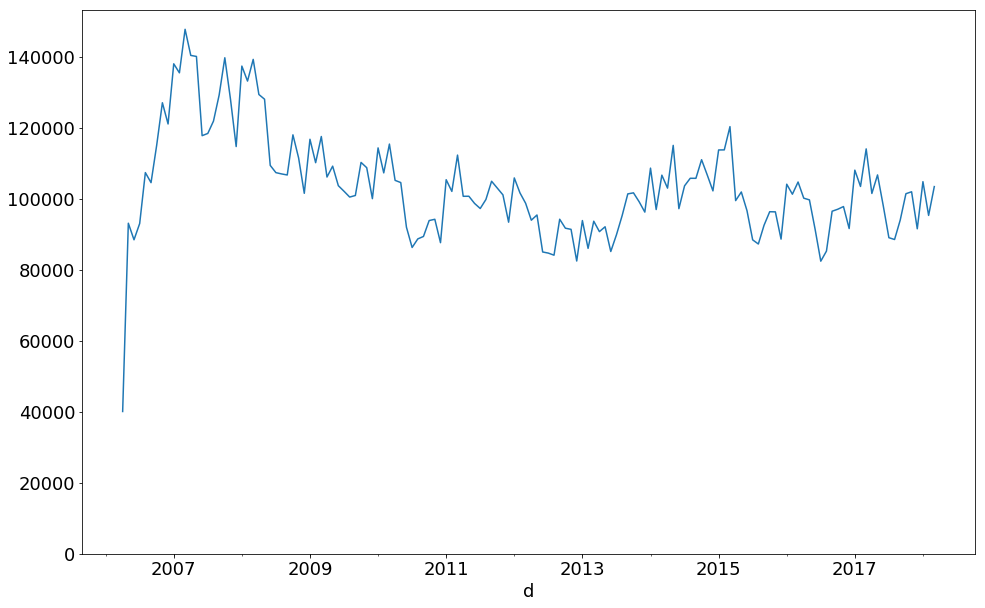

In [22]:
glob_new.plot(ylim=0);

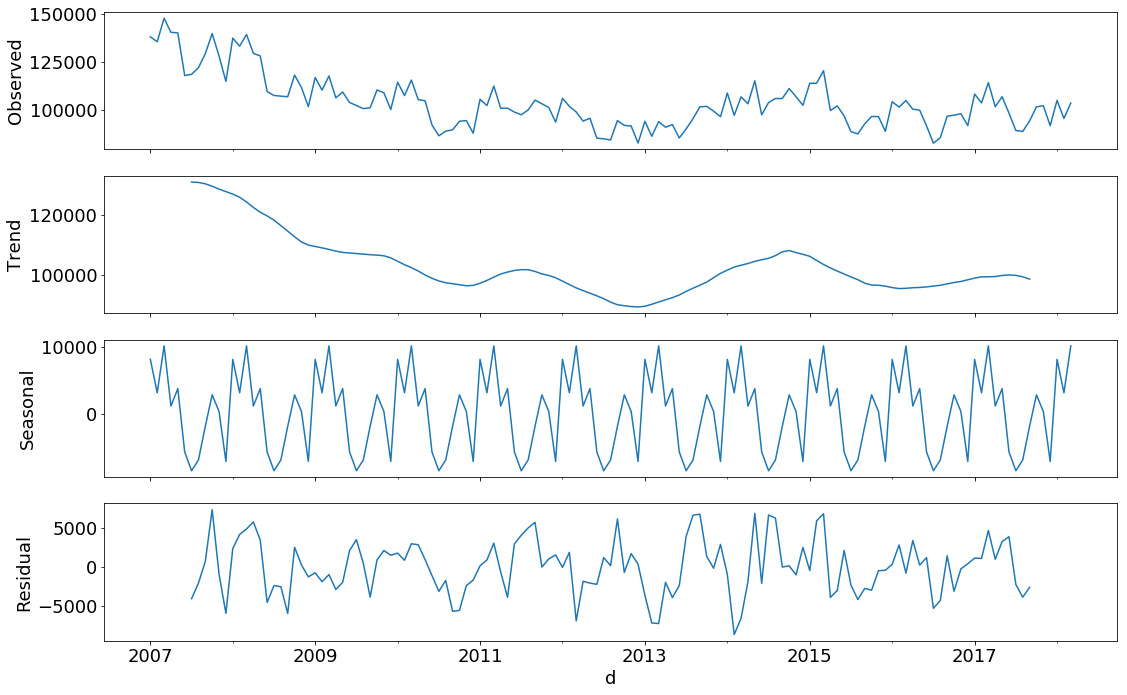

In [28]:
result = seasonal_decompose(glob_new["2007":], model='additive')
result.plot();

# New *active* editors

In [24]:
yearly_new_by_proj = run_mariadb(
"""
select
    extract(year from month) as year,
    wiki,
    avg(new_actives) as new_actives
from (
    select 
    month,
    wiki,
    sum(extract(year_month from user_registration) = extract(year_month from month)) as new_actives
    from staging.editor_month
    where
    month >= "2013-01-01" and
    content_edits >= 5 and
    local_user_id != 0 and
    bot_flag = 0 and
    convert(user_name using utf8) not regexp "bot\\b" and
    convert(user_name using utf8) not regexp "[ _]bot[ _]"
    group by month, wiki
) monthly_new
group by extract(year from month), wiki
"""
)

/home/neilpquinn-wmf/venv/lib/python3.4/site-packages/pymysql/cursors.py:323: Warning: (1300, "Invalid utf8 character string: 'F0908C'")
  self._do_get_result()
/home/neilpquinn-wmf/venv/lib/python3.4/site-packages/pymysql/cursors.py:323: Warning: (1300, "Invalid utf8 character string: 'F0908D'")
  self._do_get_result()
/home/neilpquinn-wmf/venv/lib/python3.4/site-packages/pymysql/cursors.py:323: Warning: (1300, "Invalid utf8 character string: 'F09D94'")
  self._do_get_result()
/home/neilpquinn-wmf/venv/lib/python3.4/site-packages/pymysql/cursors.py:323: Warning: (1300, "Invalid utf8 character string: 'F09D96'")
  self._do_get_result()
/home/neilpquinn-wmf/venv/lib/python3.4/site-packages/pymysql/cursors.py:323: Warning: (1300, "Invalid utf8 character string: 'F09D92'")
  self._do_get_result()
/home/neilpquinn-wmf/venv/lib/python3.4/site-packages/pymysql/cursors.py:323: Warning: (1300, "Invalid utf8 character string: 'F0A08D'")
  self._do_get_result()


In [ ]:
yearly_new_by_proj.head()

In [46]:
wikis = yearly_new_by_proj.wiki.unique()

In [48]:
years = np.arange(2013, 2018)

In [58]:
wiki_year = yearly_new_by_proj.set_index(["wiki", "year"])
wiki_year = wiki_year.reindex(pd.MultiIndex.from_product([wikis, years], names=['wiki', 'year'])).fillna(0)

In [108]:
wiki_year.groupby(level = "wiki").agg(lambda x: x.iloc[4] - x.iloc[1]).reset_index().sort_values(by = "new_actives", ascending = False)

,wiki,new_actives
683,wikidatawiki,353.0000
93,commonswiki,142.3334
601,tawiki,76.3333
176,fawiki,71.5833
60,bnwiki,20.9167
166,etwiki,17.8334
412,mrwiki,17.0834
701,zh_yuewiki,14.4167
151,enwiktionary,13.6666
246,hiwiki,13.5000


# Seasonal analysis

In [ ]:
monthly_new = wmf.mariadb.run("""
    select 
        month, 
        sum(extract(year_month from reg) = extract(year_month from month)) as new_active_editors
    from (
        select 
            month, user_name, sum(content_edits) as content_edits, 
            min(user_registration) as reg, max(bot_flag) as bot_flag
        from staging.editor_month
        where local_user_id != 0
        group by month, user_name
    ) global_edits
    where
        content_edits >= 5 and 
        bot_flag = 0 and
        convert(user_name using utf8) not regexp "bot\\b" and
        convert(user_name using utf8) not regexp "[ _]bot[ _]"
    group by month
""")

In [37]:
monthly_new = monthly_new.set_index(pd.DatetimeIndex(monthly_new["month"])).drop("month", axis = 1)

In [38]:
monthly_new.head()

,new_active_editors
month,
1970-01-01,0.0
2001-01-01,4.0
2001-02-01,3.0
2001-03-01,9.0
2001-04-01,1.0


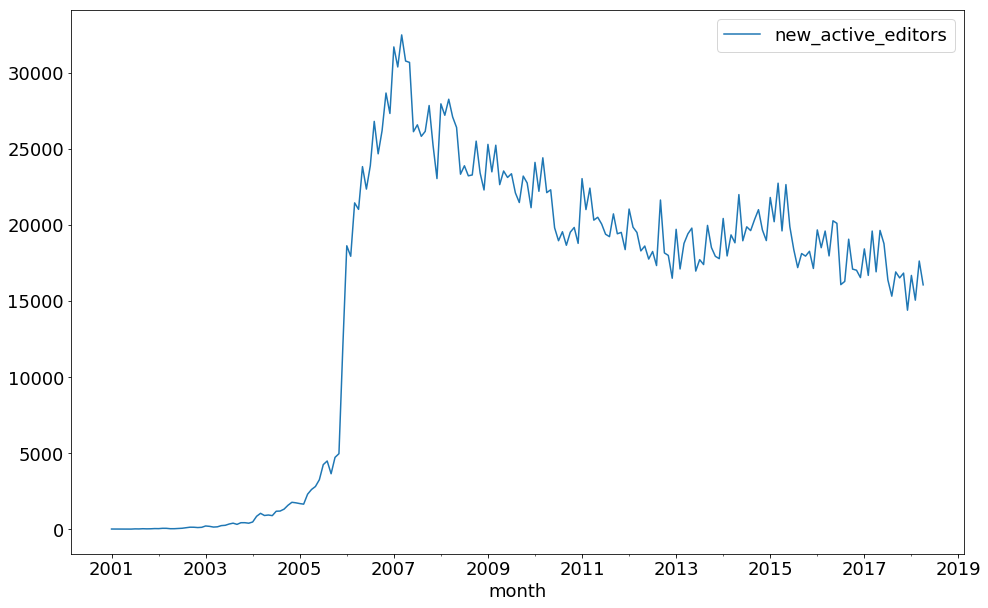

In [41]:
monthly_new.plot();

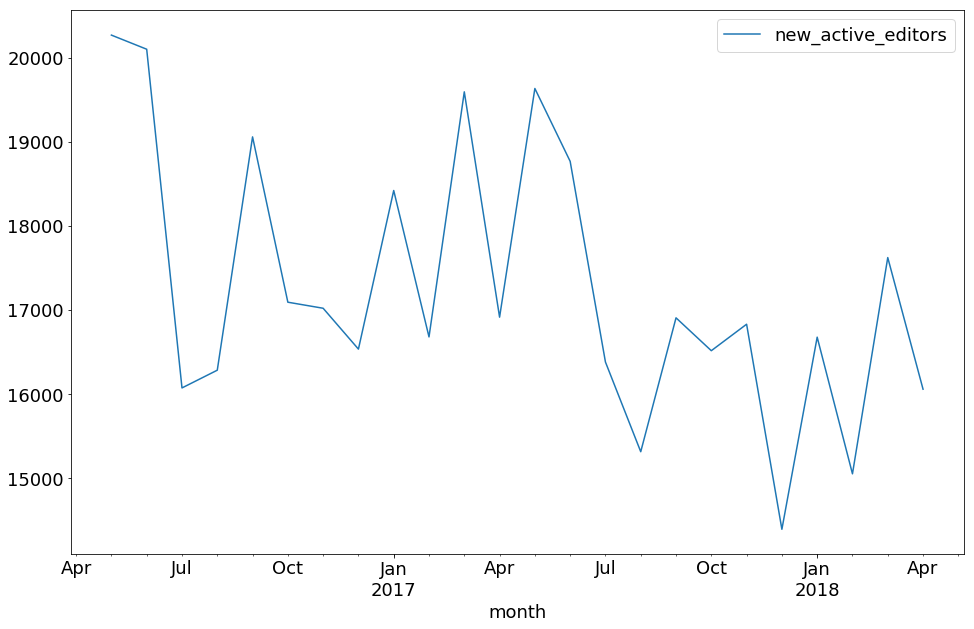

In [45]:
monthly_new["2016-05-01":].plot()

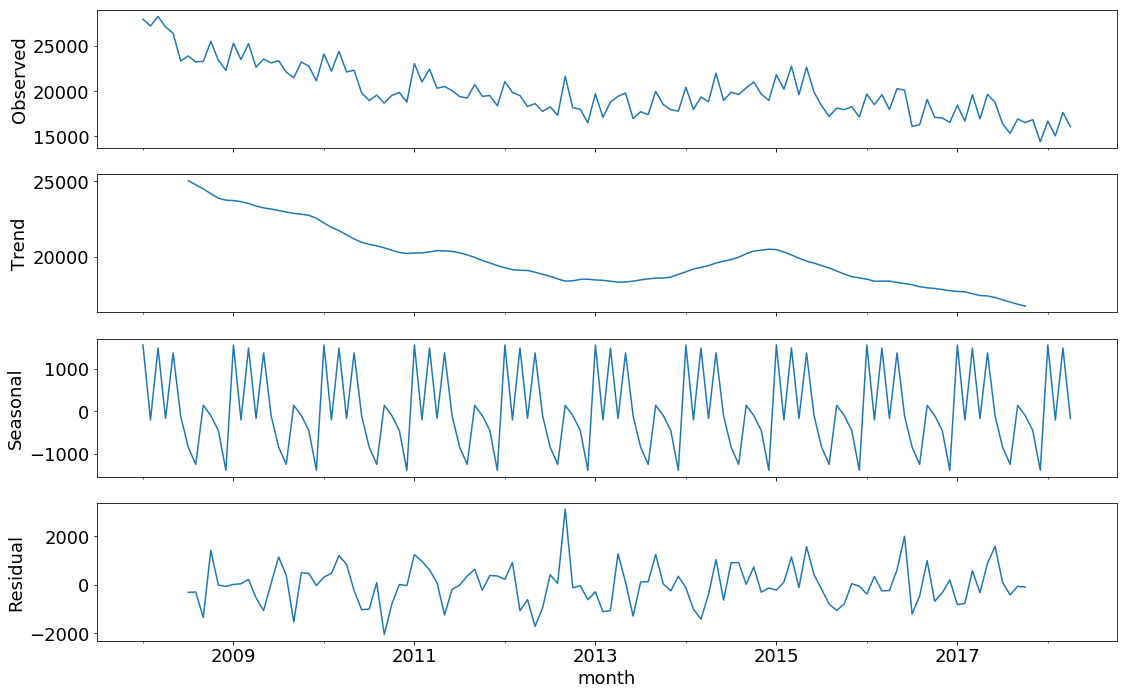

In [42]:
new_act_decomp = seasonal_decompose(monthly_new.loc["2008-01-01":], model='additive')
new_act_decomp.plot();

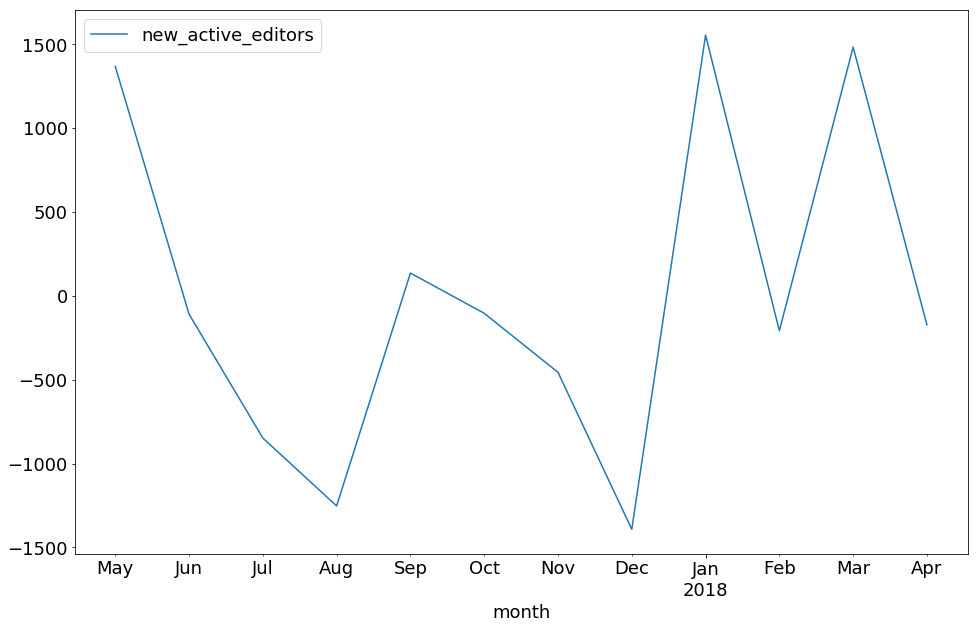

In [43]:
new_act_decomp.seasonal.tail(12).plot()

# Additional things to investigate:
* Correlation between size of new editor cohort and its retention?
* Correlations between registrations and new editors?